### Solving  $\frac{\delta}{\delta t}\phi = \frac{\delta^2}{\delta x^2}\phi$ with Dirichlet boundary conditions

Representing $\phi$ as spline of order $k$: $\phi(x) = \sum_i{c_i(t)\cdot B^{k}_i(x)}$

Reformulation : $\sum_i{B^{(k)}_i(x)\cdot \delta_t c_i(t)} = \sum_i c_i(t) \cdot \delta_x^2 B^{(k)}_i $

now let : 
* $A_{ij}$- matrix contains the second order derivative in the collocation points $x_j$
* $B_{ij}$- matrix contains 0 order derivative in the collocation points $x_j$
* $c_i$- vector contain the coefficients/weights for the respecitve basic spline

Then: $\delta_t c = B^{-1}\cdot A\cdot c$

such that,

$c(t + \Delta t) = (\Delta t \cdot B^{-1}\cdot A) c(t) $, 

where $(\Delta t \cdot B^{-1}\cdot A) = M $



Importing liberaries and setting up 3 B-spline matices where $i$ (colombs) indicates the $i$´th basic spline and $j$ (rows) the points $x_j$ where the Splines collocate.  

* $C_{ij}$- matrix contains 0 order derivative evaluated on a fine x gird (`xfine`)


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import scipy.linalg as spl
from bspline import Bspline
from bspline.splinelab import aptknt



x = np.linspace(0,10,10) #space grid to solve for coefficients c
xfine = np.linspace(0,10,1000) #gird to plot
dt = .05 #timesteps
t= np.arange(0,20,dt) #timegrid 
order = 5 #order of B-spline


knot_vector = aptknt(x, order) #kreates knot points with Ghost points
basis = Bspline(knot_vector,order) #Object of basic spline vectors: basis(0) gives 0´th basis spline

#==================Creating 3 Splines: A,B,C ==================================

C = basis.collmat(xfine) #spline to plot/evaluate solution once coefficients c are obtained
C[-1,-1] = 1 #sets the bottom right point to 1 instead of 0


B = basis.collmat(x) #creates the Matrix Bij
B[-1,-1] = 1 #Bottom right point to 1 instead of 0 to avoid singular matrix
Binv = spl.inv(B) 

A = basis.collmat(x,deriv_order=2) #creates Matrix Aij; 2n order derivative of splines 



Matices $A$ and $B$ are used to solve for the time dependent coefficients $c_i(t)$ using explicit Euler.
Once the demanded $c_i(t)$ are obtained, the coefficients are used to evaluate $\phi$ via the $C$ matrix, i.e.:

$\phi = \sum_i(c_i(t)\cdot C_i)$

Dirichlet boundary conditions, where $\phi(x_0)=\phi(x_N)=0$ are applied.

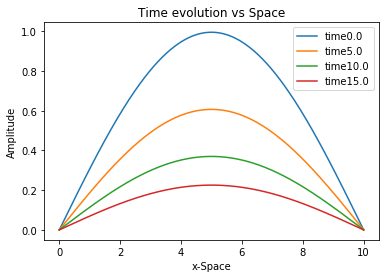

In [14]:
#================= initial coefficients =======================================
c =np.dot(Binv,np.sin(np.pi/x[-1]*x)) #+ 1-x/np.size(B,1) #starting vector for c 

#==================left and right Dirichlet boundary conditions =============== 
Bstar = B; Bstar[0] = 0; Bstar[-1] = 0
Astar = A; Astar[0] = 0; Astar[-1] = 0

bc = np.zeros(np.size(Bstar,0)); bc[0] = 0; bc[-1] = 0

M = np.dot(Binv,Bstar) + (dt*np.dot(Binv,Astar))

# ==============================Letting c(t) evolve in time=====================
phi = np.zeros((len(t),len(xfine)))
expo = np.zeros(len(t))
for i in range(len(t)):
    c = np.dot(M,c) + np.dot(Binv,bc)
    phi[i] = np.dot(C,c)
    expo[i] = phi[i][499]
    if i%100 == 0:
        plt.plot(xfine,phi[i], label = 'time'+str(t[i]))
plt.ylabel('Amplitude')        
plt.xlabel('x-Space') 
plt.title('Time evolution vs Space')
plt.legend(loc='best')
plt.show()

        

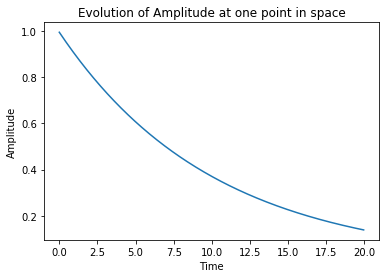

In [15]:
plt.plot(t,expo)
plt.ylabel('Amplitude')        
plt.xlabel('Time') 
plt.title('Evolution of Amplitude at one point in space')
plt.show()


Dirichlet boundary conditions, where $\phi(x_0)= 1$ and  $\phi(x_N)=0$ are applied.
Therefor the starting vector or for the weights $c$ is modified and set to 0, illustrating a probe in thermal equilibrium.

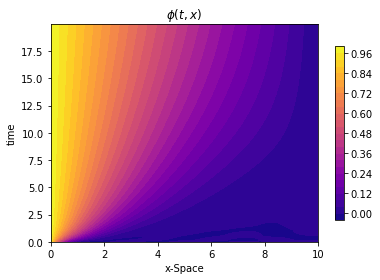

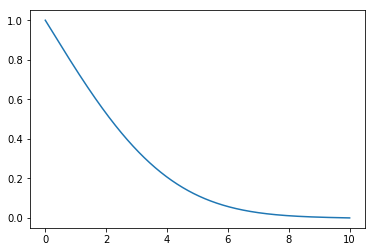

In [62]:
c= np.zeros(np.size(B,1))

Bstar = B; Bstar[0] = 0; Bstar[-1] = 0
Astar = A; Astar[0] = 0; Astar[-1] = 0

bc = np.zeros(np.size(Bstar,0)); bc[0] = 1; bc[-1] = 0

M = np.dot(Binv,Bstar) + (dt*np.dot(Binv,Astar))

phi = np.zeros((len(t),len(xfine)))
for i in range(len(t)):
    c = np.dot(M,c) + np.dot(Binv,bc)
    phi[i] = np.dot(C,c)
    
plt.contourf(xfine,t,phi,30,cmap = 'plasma')
plt.colorbar( orientation='vertical', shrink=0.8)
plt.xlabel('x-Space')
plt.ylabel('time')
plt.title(r'$\phi(t,x)$')
plt.show()    

Instead of constant Dirichlet boundary condition, where $\phi(x_0)=\phi(x_N)=0$ we will now apply boundary Dirichlet boundary conditions as a function of time,i.e. $\phi(x_0) = gauss(t)$ and $\phi(x_N) = 0$

In [81]:
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

left = gaussian(t,5,1)    # LHS boundary condition      
    
c= np.zeros(np.size(B,1)) # starting from a state in equilibrium

Bstar = B; Bstar[0] = 0; Bstar[-1] = 0
Astar = A; Astar[0] = 0; Astar[-1] = 0

bc = np.zeros(np.size(Bstar,0)); bc[0] = left[0]; bc[-1] = 0 #RHS boundary stays constantly 0

M = np.dot(Binv,Bstar) + (dt*np.dot(Binv,Astar))


phi = np.zeros((len(t),len(xfine)))
for i in range(len(t)):
    bc[0] = left[i] #Updating the LHS boundary with thime
    c = np.dot(M,c) + np.dot(Binv,bc)
    phi[i] = np.dot(C,c)

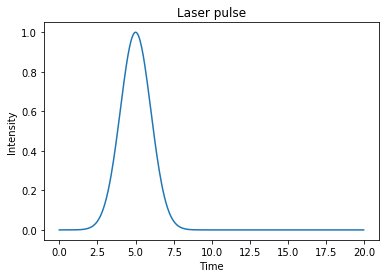

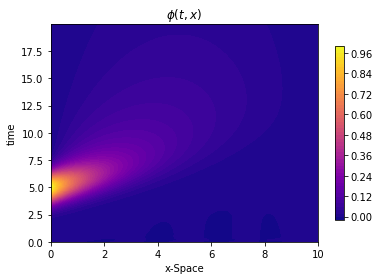

In [82]:
plt.plot(t,left)
plt.xlabel('Time')
plt.ylabel('Intensity')
plt.title('Laser pulse')
plt.show()    

plt.contourf(xfine,t,phi,50,cmap = 'plasma')
plt.colorbar( orientation='vertical', shrink=0.8)
plt.xlabel('x-Space')
plt.ylabel('time')
plt.title(r'$\phi(t,x)$')
plt.show() 

Dependencies: 
* [Numpy](http://www.numpy.org/)
* [Matplotliv](https://matplotlib.org/)
* [Scipy](https://www.scipy.org/)
* [Bspline](https://github.com/johntfoster/bspline)